In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytz
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.vectorized import contains
import matplotlib.patches as mpatches

# # Load dataset
# ncfile = '/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc'
# ds = xr.open_dataset(ncfile)

# # Convert the dataset's time dimension from UTC to AEDT
# ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')

# # Now, explicitly select the desired AEDT time without further conversion
# aedttime = pd.Timestamp('2003-12-03T00:30:00', tz='Australia/Melbourne')

# # Select nearest time in dataset (AEDT-aware)
# precip_hour = ds['pr'].sel(time=aedttime, method='nearest')

# # Convert to mm/min
# precip_mm_min = precip_hour * 60

# # Meshgrid for plotting
# lon2d, lat2d = np.meshgrid(ds['lon'].values, ds['lat'].values)

# # Plot
# fig = plt.figure(figsize=(10,8))
# ax = plt.axes(projection=ccrs.PlateCarree())

# pcm = ax.pcolormesh(lon2d, lat2d, precip_mm_min, cmap='Blues', vmin=0, vmax=1, shading='auto')
# plt.colorbar(pcm, ax=ax, label='Precipitation (mm/min)')

# ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
# ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':')
# ax.gridlines(draw_labels=True, linestyle='--')

# # Zoom into Melbourne
# ax.set_extent([144.5, 146.0, -38.5, -37.0])

# ax.set_title(f'BARRA Precipitation at {aedttime.strftime("%Y-%m-%d %H:%M %Z")}')

# plt.show()


In [11]:
shape_path = '/g/data/w28/yk8692/nesp'

Maximum precipitation: 0.59 mm/hr at (145.5800, -38.2900)


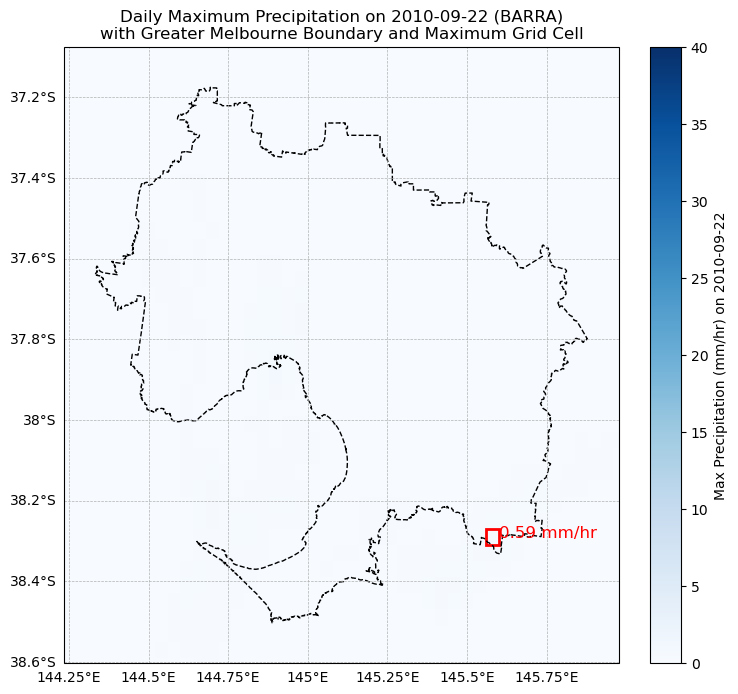

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.vectorized import contains
import matplotlib.patches as mpatches

# Load BARRA dataset and convert time to AEDT
# ncfile = '/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc'
ncfile = '/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_201009-201009.nc'
ds = xr.open_dataset(ncfile)
ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
date = "2010-09-22"
# Subset data for the day 2003-12-03 and compute daily max precipitation (mm/hr)
ds_day = ds.sel(time=date)
daily_max = ds_day['pr'].max(dim='time') * 3600  # convert to mm/hr

# Load Greater Melbourne shapefile and reproject to EPSG:4326 (WGS84)
file_path = '/g/data/w28/yk8692/nesp'
gccsa = gpd.read_file(f"{file_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)].to_crs(epsg=4326)

# Get the bounding box for Greater Melbourne from the shapefile
minx, miny, maxx, maxy = mel_shp.total_bounds

# Create meshgrid for spatial coordinates (centers of grid cells)
lon_vals = ds['lon'].values
lat_vals = ds['lat'].values
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)

# Create a mask for grid cells that are within the Greater Melbourne polygon
# (using the union of all Melbourne polygons)
mel_poly = mel_shp.unary_union
mask = contains(mel_poly, lon2d, lat2d)

# Mask the daily maximum precipitation values so that values outside Melbourne become NaN
daily_max_masked = np.where(mask, daily_max.values, np.nan)

# Find the maximum value within the Melbourne region and its index
max_idx = np.nanargmax(daily_max_masked)
i_max, j_max = np.unravel_index(max_idx, daily_max_masked.shape)
max_val = daily_max_masked[i_max, j_max]
max_lon = lon2d[i_max, j_max]
max_lat = lat2d[i_max, j_max]
print(f"Maximum precipitation: {max_val:.2f} mm/hr at ({max_lon:.4f}, {max_lat:.4f})")

# Calculate grid resolution (assuming regular grid)
lon_res = np.mean(np.diff(lon_vals))
lat_res = np.mean(np.diff(lat_vals))

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot daily maximum precipitation
pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto',
                     transform=ccrs.PlateCarree())
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.04)
cbar.set_label(f'Max Precipitation (mm/hr) on {date}')

# Overlay the Greater Melbourne boundary from the shapefile
mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())

# Draw a red box around the grid cell with the maximum precipitation within Melbourne
# The box is drawn using the grid cell center and half the resolution on each side.
rect = mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2),
                          lon_res, lat_res,
                          linewidth=2, edgecolor='red', facecolor='none',
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Optionally, label the box with the max value
ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.2f} mm/hr', color='red',
        fontsize=12, transform=ccrs.PlateCarree())

# Set extent to the Greater Melbourne region with a small padding
padding = 0.1
ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding], crs=ccrs.PlateCarree())

# Add gridlines and adjust labels (disable top/right)
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabels_top = False
gl.ylabels_right = False

ax.set_title(f"Daily Maximum Precipitation on {date} (BARRA)\nwith Greater Melbourne Boundary and Maximum Grid Cell")
plt.show()


In [3]:
# Define file path and region name (can be set to any region of interest)
file_path = '/g/data/w28/yk8692/nesp/testing_script'
region_name = 'Melbourne'  # Change this to any target region name
stations = pd.read_excel('/g/data/w28/yk8692/nesp/station/All_stations_information.xlsx')
# Load the Australian GCCSA shapefile
gccsa = gpd.read_file(f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
print("Shapefile columns:", gccsa.columns.tolist())

# Filter the shapefile for the target region by name (case-insensitive match)
target_region_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)]
print(f"Number of polygons for Greater {region_name}:", len(target_region_shp))

# Convert station metadata into a GeoDataFrame.
# The 'stations' DataFrame should include 'station', 'Longitude', and 'Latitude' columns.
stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['Longitude'], stations['Latitude']),
    crs="EPSG:4326"
)

# Reproject the region shapefile to match the stations' CRS if necessary
if target_region_shp.crs != stations_gdf.crs:
    target_region_shp = target_region_shp.to_crs(stations_gdf.crs)

# Filter stations that fall within the target region
stations_in_region = stations_gdf[stations_gdf.within(target_region_shp.unary_union)]
print(f"Found {len(stations_in_region)} AWS stations within the {region_name} region.")

Shapefile columns: ['GCC_CODE21', 'GCC_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'geometry']
Number of polygons for Greater Melbourne: 1
Found 16 AWS stations within the Melbourne region.


Maximum precipitation: 44.44 mm/hr at (145.1400, -37.5700)


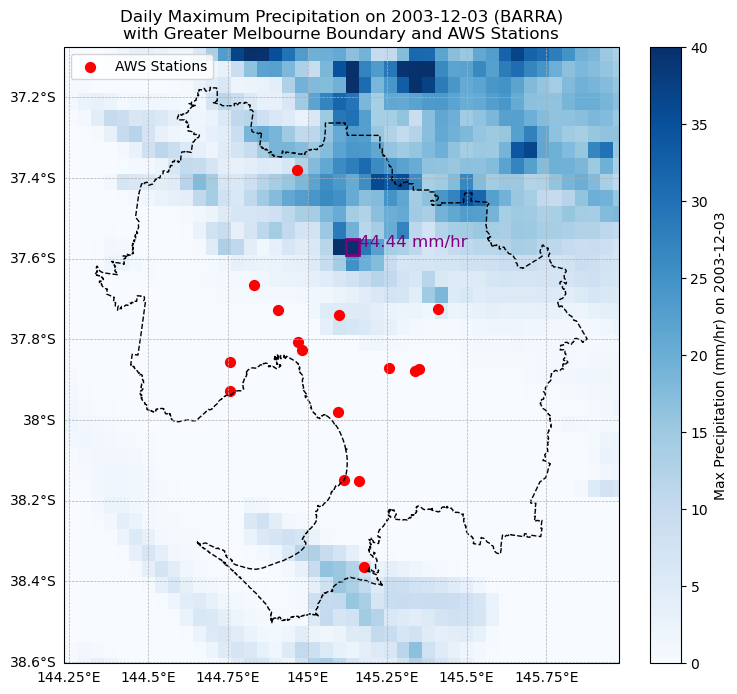

In [40]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.vectorized import contains
import matplotlib.patches as mpatches

# Load BARRA dataset and convert time to AEDT
ncfile = '/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc'
ds = xr.open_dataset(ncfile)
ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
date = "2003-12-03"
# Subset data for the day 2003-12-03 and compute daily max precipitation (mm/hr)
ds_day = ds.sel(time=date)
daily_max = ds_day['pr'].max(dim='time') * 3600  # convert to mm/hr

# Load Greater Melbourne shapefile and reproject to EPSG:4326 (WGS84)
file_path = '/g/data/w28/yk8692/nesp'
gccsa = gpd.read_file(f"{file_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)].to_crs(epsg=4326)

# Get the bounding box for Greater Melbourne from the shapefile
minx, miny, maxx, maxy = mel_shp.total_bounds

# Create meshgrid for spatial coordinates (cell centers)
lon_vals = ds['lon'].values
lat_vals = ds['lat'].values
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)

# Create a mask for grid cells that are within the Greater Melbourne polygon
mel_poly = mel_shp.unary_union
mask = contains(mel_poly, lon2d, lat2d)

# Mask the daily maximum precipitation so that values outside Melbourne become NaN
daily_max_masked = np.where(mask, daily_max.values, np.nan)

# Find the maximum value within the Melbourne region and its index
max_idx = np.nanargmax(daily_max_masked)
i_max, j_max = np.unravel_index(max_idx, daily_max_masked.shape)
max_val = daily_max_masked[i_max, j_max]
max_lon = lon2d[i_max, j_max]
max_lat = lat2d[i_max, j_max]
print(f"Maximum precipitation: {max_val:.2f} mm/hr at ({max_lon:.4f}, {max_lat:.4f})")

# Calculate grid resolution (assuming regular grid)
lon_res = np.mean(np.diff(lon_vals))
lat_res = np.mean(np.diff(lat_vals))

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot daily maximum precipitation
pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto',
                     transform=ccrs.PlateCarree())
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.04)
cbar.set_label(f'Max Precipitation (mm/hr) on {date}')

# Overlay the Greater Melbourne boundary
mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())

# Draw a red box around the grid cell with the maximum precipitation
rect = mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2),
                          lon_res, lat_res,
                          linewidth=2, edgecolor='purple', facecolor='none',
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)
ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.2f} mm/hr', color='purple', fontsize=12,
        transform=ccrs.PlateCarree())

# Set extent to the Greater Melbourne region with a small padding
padding = 0.1
ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding], crs=ccrs.PlateCarree())

# Plot AWS stations from the stations_in_region GeoDataFrame.
# (Assuming stations_in_region is already defined with a geometry column in EPSG:4326.)
if 'stations_in_region' in globals():
    stations_in_region.plot(ax=ax, marker='o', color='red', markersize=50,
                             transform=ccrs.PlateCarree(), label='AWS Stations')

# Add gridlines and adjust labels (disable top/right)
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabels_top = False
gl.ylabels_right = False

# Add a legend for the AWS stations
plt.legend(loc='upper left')

ax.set_title(f"Daily Maximum Precipitation on {date} (BARRA)\nwith Greater Melbourne Boundary and AWS Stations")
# plt.savefig(f'{file_path}/figure/dailymax_barra_map_melbourne_{date}.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


Processing date: 2003-12-03
Date 2003-12-03: Maximum precipitation: 44.44 mm/hr at (145.1400, -37.5700)
Processing date: 2004-11-15
Date 2004-11-15: Maximum precipitation: 0.74 mm/hr at (144.9400, -38.4900)
Processing date: 2005-01-13
Date 2005-01-13: Maximum precipitation: 0.00 mm/hr at (145.7400, -37.7300)
Processing date: 2011-02-04
Date 2011-02-04: Maximum precipitation: 49.53 mm/hr at (144.9400, -37.4100)
Processing date: 2016-12-29
Date 2016-12-29: Maximum precipitation: 59.08 mm/hr at (145.8200, -37.8100)
Processing date: 2022-03-24
Date 2022-03-24: Maximum precipitation: 0.02 mm/hr at (144.7000, -38.3300)
Processing date: 2024-01-02
Date 2024-01-02: Maximum precipitation: 38.53 mm/hr at (145.0200, -37.6500)


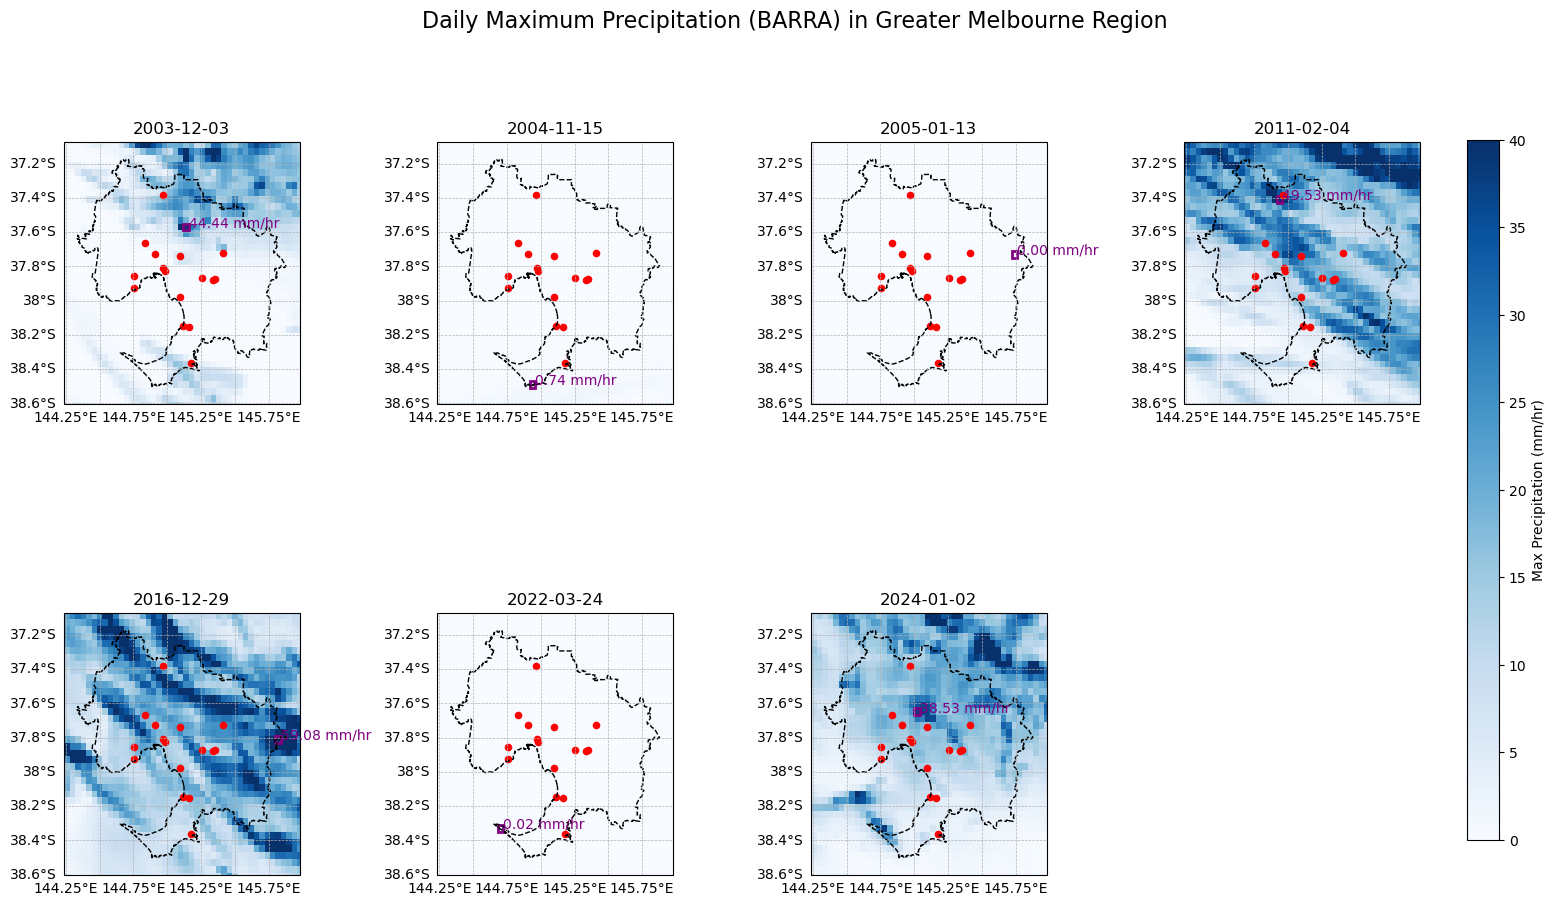

In [47]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.vectorized import contains
import matplotlib.patches as mpatches

# Define the dates to plot
dates = ["2003-12-03", "2004-11-15", "2005-01-13", "2011-02-04", "2016-12-29", "2022-03-24", "2024-01-02"]

# Base path for the monthly files (adjust if needed)
base_path = '/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004'

# Load Greater Melbourne shapefile and reproject to EPSG:4326 (WGS84)
shp_path = '/g/data/w28/yk8692/nesp/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp'
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

# Use a representative file to extract grid information (assume grid is consistent)
rep_file = f"{base_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc"
ds_rep = xr.open_dataset(rep_file)
lon_vals = ds_rep['lon'].values
lat_vals = ds_rep['lat'].values
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)
ds_rep.close()

# Create a mask for grid cells within Greater Melbourne using the union polygon
mel_poly = mel_shp.unary_union
mask = contains(mel_poly, lon2d, lat2d)

# Calculate grid resolution (assume regular grid)
lon_res = np.mean(np.diff(lon_vals))
lat_res = np.mean(np.diff(lat_vals))

# Create subplots (e.g., 2 rows x 4 columns; one extra subplot will be turned off)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
pcms = []  # to store pcolormesh objects for a common colorbar

for idx, date in enumerate(dates):
    ax = axes[idx]
    print("Processing date:", date)
    
    dt = pd.to_datetime(date)
    year = dt.year
    month = dt.month
    # Build the file name for the corresponding month
    # File naming pattern: pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_YYYYMM-YYYYMM.nc
    file_name = f"pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month:02d}-{year}{month:02d}.nc"
    file_path_full = f"{base_path}/{file_name}"
    
    # Load the monthly file for that date
    ds_month = xr.open_dataset(file_path_full)
    ds_month['time'] = pd.to_datetime(ds_month['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    
    # Subset data for the specific date (using method='nearest' in case an exact match is not found)
    ds_day = ds_month.sel(time=slice(date, date))
    
    # Compute daily maximum precipitation (BARRA pr is in kg m⁻² s⁻¹; multiply by 3600 to get mm/hr)
    if 'time' in ds_day['pr'].dims:
        daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    else:
        daily_max = ds_day['pr'] * 3600  # mm/hr
    ds_month.close()
    
    # Mask values outside Greater Melbourne
    daily_max_masked = np.where(mask, daily_max.values, np.nan)
    
    # Find the maximum value within the Melbourne region and its index
    max_idx = np.nanargmax(daily_max_masked)
    i_max, j_max = np.unravel_index(max_idx, daily_max_masked.shape)
    max_val = daily_max_masked[i_max, j_max]
    max_lon = lon2d[i_max, j_max]
    max_lat = lat2d[i_max, j_max]
    print(f"Date {date}: Maximum precipitation: {max_val:.2f} mm/hr at ({max_lon:.4f}, {max_lat:.4f})")
    
    # Plot the daily maximum precipitation field
    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40,
                         shading='auto', transform=ccrs.PlateCarree())
    pcms.append(pcm)
    
    # Overlay the Greater Melbourne boundary
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())
    
    # Draw a purple box around the grid cell with the maximum precipitation
    rect = mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2),
                              lon_res, lat_res,
                              linewidth=2, edgecolor='purple', facecolor='none',
                              transform=ccrs.PlateCarree())
    ax.add_patch(rect)
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.2f} mm/hr', color='purple', fontsize=10,
            transform=ccrs.PlateCarree())
    
    # Overlay AWS stations if available (assuming stations_in_region is defined as a GeoDataFrame)
    if 'stations_in_region' in globals():
        stations_in_region.plot(ax=ax, marker='o', color='red', markersize=10,
                                 transform=ccrs.PlateCarree(), label='AWS Stations')
    
    # Set the map extent to the Greater Melbourne region with a small padding
    padding = 0.1
    ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding], crs=ccrs.PlateCarree())
    
    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    ax.set_title(f"{date}", fontsize=12)

# Turn off any unused subplot(s)
if len(dates) < len(axes):
    for ax in axes[len(dates):]:
        ax.set_visible(False)

# Add a common colorbar using the first pcolormesh as reference
# cbar = fig.colorbar(pcms[0], ax=axes.tolist(), orientation='vertical', fraction=0.025, pad=0.02)
# cbar.set_label('Max Precipitation (mm/hr)')

plt.suptitle("Daily Maximum Precipitation (BARRA) in Greater Melbourne Region", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # reserve space on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] in figure coordinates
cbar = fig.colorbar(pcms[0], cax=cbar_ax, orientation='vertical')
cbar.set_label('Max Precipitation (mm/hr)')

save_fname = f'{base_path}/figure/dailymax_barra_map_melbourne_all_dates.jpg'
# plt.savefig(save_fname, format='jpg', dpi=300, bbox_inches='tight')
# print(f"Saved combined figure to: {save_fname}")
plt.show()


In [46]:
import pickle
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
with open(f'{directory_path}/p2_top_10_events_all_stations.pkl', 'rb') as f:
    top_10_events_all_stations = pickle.load(f)

interval_order = ['10min', '1h']

# Define the interval order
# interval_order = ['5min', '10min', '20min', '30min', '1h']

# Create a new dictionary to hold the filtered events
filtered_top_10_events_all_stations = {}

for station, events in top_10_events_all_stations.items():
    common_dates = None  # Holds the intersection of dates across all available intervals

    # Identify common dates across available intervals
    for interval in interval_order:
        if interval in events and not events[interval].empty:
            dates = set(events[interval]['Date'].unique())
            common_dates = dates if common_dates is None else common_dates.intersection(dates)

    # If common dates exist, filter each DataFrame accordingly
    if common_dates:
        filtered_events = {
            interval: events[interval][events[interval]['Date'].isin(common_dates)]
            for interval in interval_order if interval in events and not events[interval].empty
        }
        if filtered_events:  # Only store if there are matching events
            filtered_top_10_events_all_stations[station] = filtered_events

print(f"Filtering complete. {len(filtered_top_10_events_all_stations)} stations have common events.")


shape_path = '/g/data/w28/yk8692/nesp'
target_region = 'Melbourne'
# Define the interval order (if not defined already)
interval_order = ['10min', '1h']

print(f"Filtering complete. {len(filtered_top_10_events_all_stations)} stations have common events.")

# ----------------------------------------------------------
# Compute global top 10 1h events across all stations
# ----------------------------------------------------------
global_1h_events = []
for station, events in filtered_top_10_events_all_stations.items():
    if '1h' in events:
        df = events['1h'][['Date', 'Precipitation']].copy()
        # Ensure the Date is a string
        df['Date'] = df['Date'].astype(str)
        # Enumerate events in the order they appear (assumed to be pre-filtered top events)
        for rank, row in enumerate(df.itertuples(index=False), start=1):
            global_1h_events.append({
                'station': station,
                'rank': rank,
                'date': row.Date,
                'precipitation': row.Precipitation
            })

# Sort the events by precipitation in descending order and select the top 10
global_top10 = sorted(global_1h_events, key=lambda x: x['precipitation'], reverse=True)[:10]
# Create a set of (station, rank) keys for quick lookup when plotting
global_top10_keys = {(event['station'], event['rank']) for event in global_top10}

# --- Prepare Global Top 10 Data ---
# Convert the global_top10 list into a DataFrame
global_top10_df = pd.DataFrame(global_top10)

# Convert the 'date' column to datetime and create a 'Time' column (if not already datetime)
global_top10_df['Time'] = pd.to_datetime(global_top10_df['date'])

# Merge with station metadata; note: using 'Station_name' from stations for matching
# global_top10_df = global_top10_df.merge(
#     stations[['station', 'Longitude', 'Latitude']],
#     left_on='station', right_on='station',
#     how='left'
# )

global_top10_df = global_top10_df.merge(
    stations[['Station_name', 'Longitude', 'Latitude']],
    left_on='station', right_on='Station_name', how='left'
)

print(global_top10_df)

Filtering complete. 15 stations have common events.
Filtering complete. 15 stations have common events.
                       station  rank        date  precipitation       Time  \
0     MELBOURNE (OLYMPIC PARK)     1  2022-03-24           92.6 2022-03-24   
1                     VIEWBANK     1  2003-12-03           78.0 2003-12-03   
2                     VIEWBANK     2  2016-12-29           71.6 2016-12-29   
3    MELBOURNE REGIONAL OFFICE     1  2005-01-13           62.0 2005-01-13   
4    MELBOURNE REGIONAL OFFICE     2  2004-11-15           58.2 2004-11-15   
5                  FERNY CREEK     1  2016-12-29           54.4 2016-12-29   
6                   COLDSTREAM     1  2024-01-02           54.0 2024-01-02   
7     FERNY CREEK (DUNNS HILL)     1  2011-02-04           49.4 2011-02-04   
8  SCORESBY RESEARCH INSTITUTE     1  2016-12-29           48.4 2016-12-29   
9            MOORABBIN AIRPORT     1  2011-02-04           47.2 2011-02-04   

                  Station_name  Longi

Processing date: 2003-12-03
Date 2003-12-03: Maximum precipitation: 44.44 mm/hr at (145.1400, -37.5700)
Processing date: 2004-11-15
Date 2004-11-15: Maximum precipitation: 0.74 mm/hr at (144.9400, -38.4900)
Processing date: 2005-01-13
Date 2005-01-13: Maximum precipitation: 0.00 mm/hr at (145.7400, -37.7300)
Processing date: 2011-02-04
Date 2011-02-04: Maximum precipitation: 49.53 mm/hr at (144.9400, -37.4100)
Processing date: 2016-12-29
Date 2016-12-29: Maximum precipitation: 59.08 mm/hr at (145.8200, -37.8100)
Processing date: 2022-03-24
Date 2022-03-24: Maximum precipitation: 0.02 mm/hr at (144.7000, -38.3300)
Processing date: 2024-01-02
Date 2024-01-02: Maximum precipitation: 38.53 mm/hr at (145.0200, -37.6500)
Saved combined figure to: /g/data/w28/yk8692/nesp/figure/dailymax_barra_map_melbourne_all_top10_dates.jpg


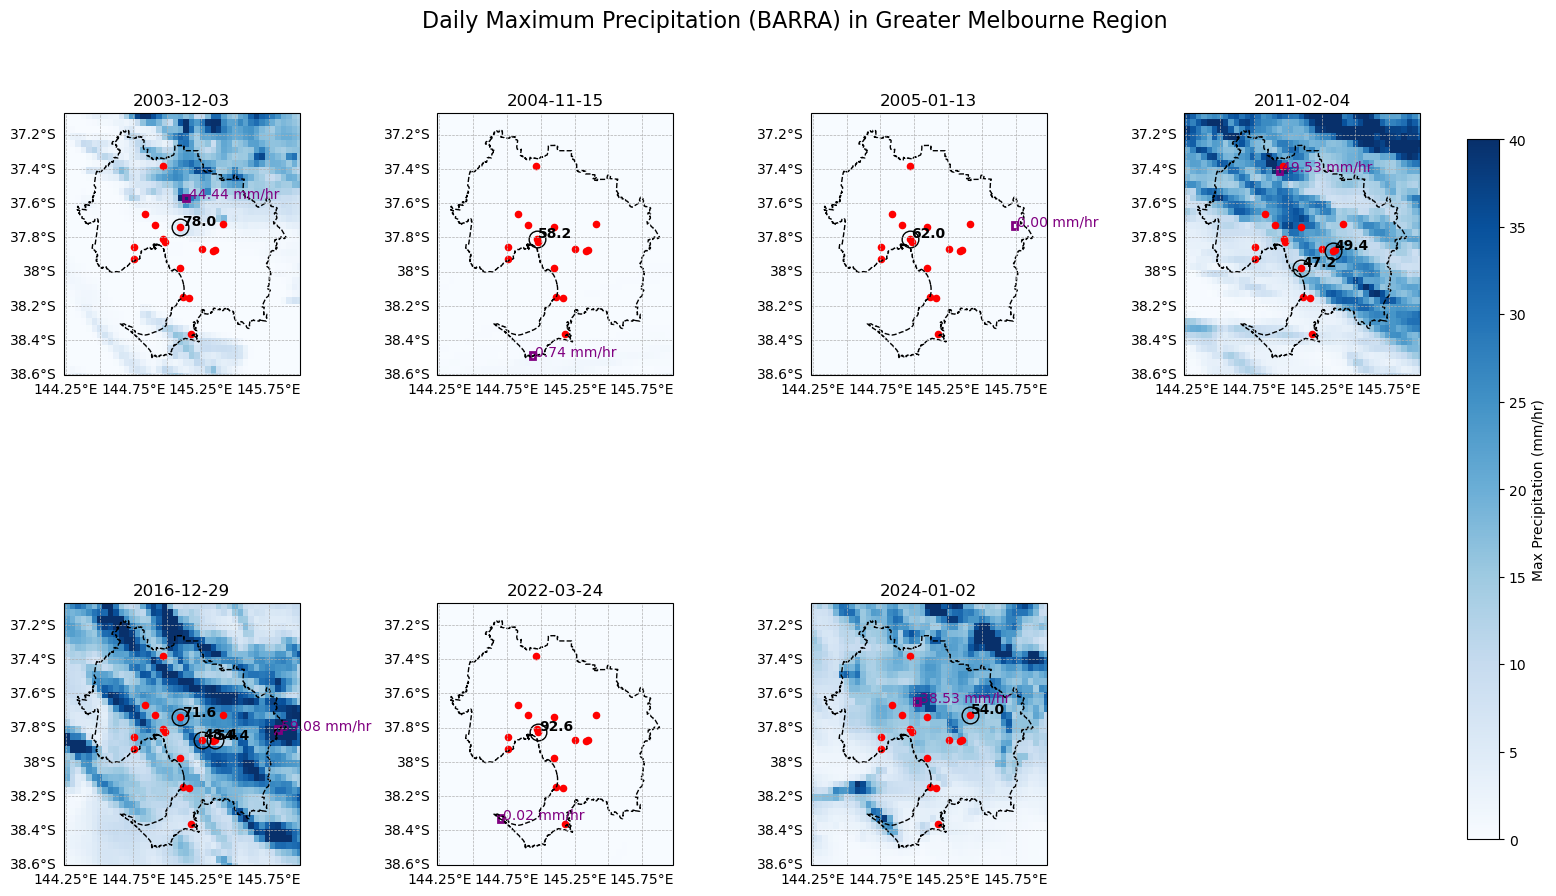

In [52]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.vectorized import contains
import matplotlib.patches as mpatches

# Define the dates to plot
dates = ["2003-12-03", "2004-11-15", "2005-01-13", "2011-02-04", "2016-12-29", "2022-03-24", "2024-01-02"]

# Base path for the monthly files (adjust if needed)
base_path = '/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004'

# File naming pattern: e.g.
# pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_YYYYMM-YYYYMM.nc
file_pattern_template = f"/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{{year}}{{month:02d}}-{{year}}{{month:02d}}.nc"

# Load Greater Melbourne shapefile and reproject to EPSG:4326 (WGS84)
shp_path = '/g/data/w28/yk8692/nesp/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp'
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

# Use a representative file to extract grid information (assumed consistent across months)
rep_file = f"{base_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc"
ds_rep = xr.open_dataset(rep_file)
lon_vals = ds_rep['lon'].values
lat_vals = ds_rep['lat'].values
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)
ds_rep.close()

# Create a common mask for grid cells within Greater Melbourne using the union polygon
mel_poly = mel_shp.unary_union
mask = contains(mel_poly, lon2d, lat2d)

# Calculate grid resolution (assuming a regular grid)
lon_res = np.mean(np.diff(lon_vals))
lat_res = np.mean(np.diff(lat_vals))

# Create subplots: e.g., 2 rows x 4 columns (one extra subplot will be turned off)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
pcms = []  # to store pcolormesh objects for a common colorbar

for idx, date in enumerate(dates):
    ax = axes[idx]
    print("Processing date:", date)
    
    dt = pd.to_datetime(date)
    year = dt.year
    month = dt.month
    # Build the file name for that month
    file_name = file_pattern_template.format(year=year, month=month)
    file_path_full = f"{base_path}/{file_name}"
    
    # Load the monthly file
    ds_month = xr.open_dataset(file_path_full)
    ds_month['time'] = pd.to_datetime(ds_month['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    
    # Select all times for that day
    ds_day = ds_month.sel(time=slice(date, date))
    
    # Compute daily maximum precipitation (BARRA pr is in kg m⁻² s⁻¹; multiply by 3600 to get mm/hr)
    if 'time' in ds_day['pr'].dims:
        daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    else:
        daily_max = ds_day['pr'] * 3600  # mm/hr
    ds_month.close()
    
    # Mask values outside Greater Melbourne
    daily_max_masked = np.where(mask, daily_max.values, np.nan)
    
    # Find the maximum value within Melbourne region and its index
    max_idx = np.nanargmax(daily_max_masked)
    i_max, j_max = np.unravel_index(max_idx, daily_max_masked.shape)
    max_val = daily_max_masked[i_max, j_max]
    max_lon = lon2d[i_max, j_max]
    max_lat = lat2d[i_max, j_max]
    print(f"Date {date}: Maximum precipitation: {max_val:.2f} mm/hr at ({max_lon:.4f}, {max_lat:.4f})")
    
    # Plot the daily maximum precipitation field
    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40,
                         shading='auto', transform=ccrs.PlateCarree())
    pcms.append(pcm)
    
    # Overlay the Greater Melbourne boundary
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--',
                          transform=ccrs.PlateCarree())
    
    # Draw a purple box around the grid cell with the maximum precipitation
    rect = mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2),
                              lon_res, lat_res,
                              linewidth=2, edgecolor='purple', facecolor='none',
                              transform=ccrs.PlateCarree())
    ax.add_patch(rect)
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.2f} mm/hr', color='purple', fontsize=10,
            transform=ccrs.PlateCarree())
    
    # Overlay AWS stations:
    # First, plot all AWS stations as red dots (assuming stations_in_region is defined)
    if 'stations_in_region' in globals():
        stations_in_region.plot(ax=ax, marker='o', color='red', markersize=20,
                                 transform=ccrs.PlateCarree(), label='AWS Stations')
    
    # Next, overlay the AWS stations for this date from global_top10_df with orange edges and annotate with precipitation values
    if 'global_top10_df' in globals():
        top_stations = global_top10_df[global_top10_df['date'] == date]
        for _, row in top_stations.iterrows():
            # Draw an overlay marker with an orange edge (no fill)
            ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=12,
                    markerfacecolor='none', markeredgecolor='black', linewidth=2,
                    transform=ccrs.PlateCarree())
            # Annotate with the precipitation value (from the table)
            ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01,
                    f"{row['precipitation']:.1f}", color='black', fontsize=10, fontweight='bold',
                    transform=ccrs.PlateCarree())
    
    # Set map extent to the Greater Melbourne region with a small padding
    padding = 0.1
    ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding], crs=ccrs.PlateCarree())
    
    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    ax.set_title(f"{date}", fontsize=12)

# Turn off any unused subplot(s)
if len(dates) < len(axes):
    for ax in axes[len(dates):]:
        ax.set_visible(False)

# Add a common colorbar for all subplots using the first pcolormesh as reference,
# and place it on the right.
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcms[0], cax=cbar_ax, orientation='vertical')
cbar.set_label('Max Precipitation (mm/hr)')

plt.suptitle("Daily Maximum Precipitation (BARRA) in Greater Melbourne Region", fontsize=16)
file_path = '/g/data/w28/yk8692/nesp'
save_fname = f'{file_path}/figure/dailymax_barra_map_melbourne_all_top10_dates.jpg'
plt.savefig(save_fname, format='jpg', dpi=300, bbox_inches='tight')
print(f"Saved combined figure to: {save_fname}")
plt.show()


Maximum precipitation: 44.44 mm/hr at (145.1400, -37.5700)


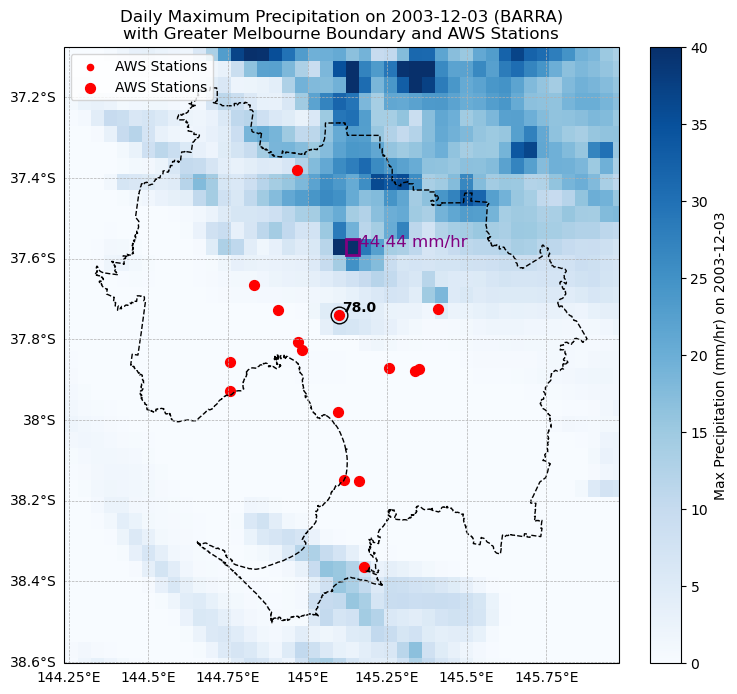

In [54]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.vectorized import contains
import matplotlib.patches as mpatches

# Load BARRA dataset and convert time to AEDT
ncfile = '/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc'
ds = xr.open_dataset(ncfile)
ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
date = "2003-12-03"
# Subset data for the day 2003-12-03 and compute daily max precipitation (mm/hr)
ds_day = ds.sel(time=date)
daily_max = ds_day['pr'].max(dim='time') * 3600  # convert to mm/hr

# Load Greater Melbourne shapefile and reproject to EPSG:4326 (WGS84)
file_path = '/g/data/w28/yk8692/nesp'
gccsa = gpd.read_file(f"{file_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)].to_crs(epsg=4326)

# Get the bounding box for Greater Melbourne from the shapefile
minx, miny, maxx, maxy = mel_shp.total_bounds

# Create meshgrid for spatial coordinates (cell centers)
lon_vals = ds['lon'].values
lat_vals = ds['lat'].values
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)

# Create a mask for grid cells that are within the Greater Melbourne polygon
mel_poly = mel_shp.unary_union
mask = contains(mel_poly, lon2d, lat2d)

# Mask the daily maximum precipitation so that values outside Melbourne become NaN
daily_max_masked = np.where(mask, daily_max.values, np.nan)

# Find the maximum value within the Melbourne region and its index
max_idx = np.nanargmax(daily_max_masked)
i_max, j_max = np.unravel_index(max_idx, daily_max_masked.shape)
max_val = daily_max_masked[i_max, j_max]
max_lon = lon2d[i_max, j_max]
max_lat = lat2d[i_max, j_max]
print(f"Maximum precipitation: {max_val:.2f} mm/hr at ({max_lon:.4f}, {max_lat:.4f})")

# Calculate grid resolution (assuming regular grid)
lon_res = np.mean(np.diff(lon_vals))
lat_res = np.mean(np.diff(lat_vals))

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot daily maximum precipitation
pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto',
                     transform=ccrs.PlateCarree())
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.04)
cbar.set_label(f'Max Precipitation (mm/hr) on {date}')

# Overlay the Greater Melbourne boundary
mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())

# Draw a red box around the grid cell with the maximum precipitation
rect = mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2),
                          lon_res, lat_res,
                          linewidth=2, edgecolor='purple', facecolor='none',
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)
ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.2f} mm/hr', color='purple', fontsize=12,
        transform=ccrs.PlateCarree())

# Overlay AWS stations:
# First, plot all AWS stations as red dots (assuming stations_in_region is defined)
if 'stations_in_region' in globals():
    stations_in_region.plot(ax=ax, marker='o', color='red', markersize=20,
                             transform=ccrs.PlateCarree(), label='AWS Stations')

# Next, overlay the AWS stations for this date from global_top10_df with orange edges and annotate with precipitation values
if 'global_top10_df' in globals():
    top_stations = global_top10_df[global_top10_df['date'] == date]
    for _, row in top_stations.iterrows():
        # Draw an overlay marker with an orange edge (no fill)
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=12,
                markerfacecolor='none', markeredgecolor='black', linewidth=2,
                transform=ccrs.PlateCarree())
        # Annotate with the precipitation value (from the table)
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01,
                f"{row['precipitation']:.1f}", color='black', fontsize=10, fontweight='bold',
                transform=ccrs.PlateCarree())
        
# Set extent to the Greater Melbourne region with a small padding
padding = 0.1
ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding], crs=ccrs.PlateCarree())

# Plot AWS stations from the stations_in_region GeoDataFrame.
# (Assuming stations_in_region is already defined with a geometry column in EPSG:4326.)
if 'stations_in_region' in globals():
    stations_in_region.plot(ax=ax, marker='o', color='red', markersize=50,
                             transform=ccrs.PlateCarree(), label='AWS Stations')

# Add gridlines and adjust labels (disable top/right)
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabels_top = False
gl.ylabels_right = False

# Add a legend for the AWS stations
plt.legend(loc='upper left')

ax.set_title(f"Daily Maximum Precipitation on {date} (BARRA)\nwith Greater Melbourne Boundary and AWS Stations")
plt.savefig(f'{file_path}/figure/dailymax_barra_map_melbourne_{date}_with_maxstation.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


Maximum precipitation: 44.44 mm/hr at (145.1400, -37.5700)


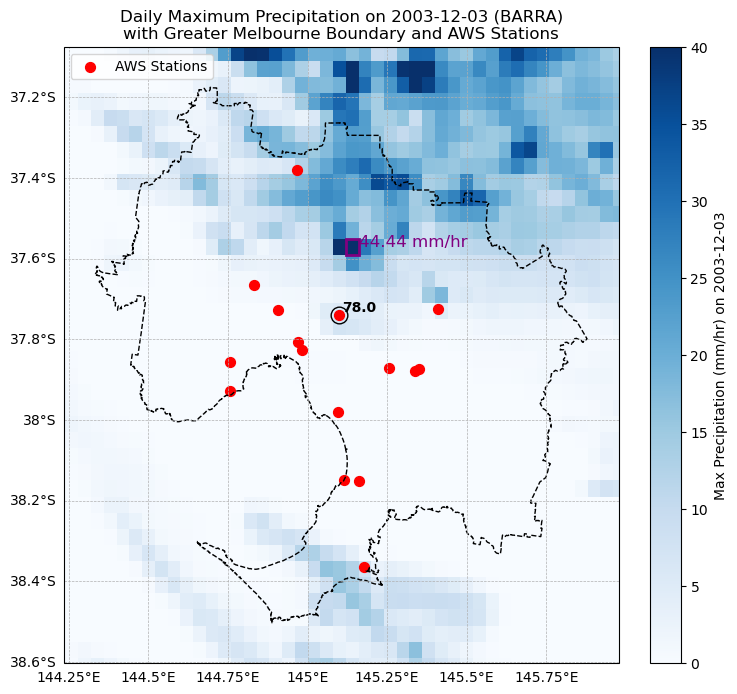

In [16]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.vectorized import contains
import matplotlib.patches as mpatches
import os

file_path = '/g/data/w28/yk8692/nesp'
date = "2003-12-03"
year = 2003
month = 12
summary_file = os.path.join(f"{file_path}/figure/", "Melbourne_top10_after_hourly_check_summary.csv")
stations_file = os.path.join(f"{file_path}/station/", "All_stations_information.xlsx")
gpd_file = os.path.join(f"{file_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/", "GCCSA_2021_AUST_GDA2020.shp")
ncfile = f'/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month}-{year}{month}.nc'

# Load BARRA dataset and convert time to AEDT
ds = xr.open_dataset(ncfile)
ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')

# Subset data for the day 2003-12-03 and compute daily max precipitation (mm/hr)
ds_day = ds.sel(time=date)
daily_max = ds_day['pr'].max(dim='time') * 3600  # convert to mm/hr

# Load Greater Melbourne shapefile and reproject to EPSG:4326 (WGS84)
gccsa = gpd.read_file(gpd_file)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)].to_crs(epsg=4326)

# Get the bounding box for Greater Melbourne from the shapefile
minx, miny, maxx, maxy = mel_shp.total_bounds

# Create meshgrid for spatial coordinates (cell centers)
lon_vals = ds['lon'].values
lat_vals = ds['lat'].values
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)

# Create a mask for grid cells that are within the Greater Melbourne polygon
mel_poly = mel_shp.unary_union
mask = contains(mel_poly, lon2d, lat2d)

# Mask the daily maximum precipitation so that values outside Melbourne become NaN
daily_max_masked = np.where(mask, daily_max.values, np.nan)

# Find the maximum value within the Melbourne region and its index
max_idx = np.nanargmax(daily_max_masked)
i_max, j_max = np.unravel_index(max_idx, daily_max_masked.shape)
max_val = daily_max_masked[i_max, j_max]
max_lon = lon2d[i_max, j_max]
max_lat = lat2d[i_max, j_max]
print(f"Maximum precipitation: {max_val:.2f} mm/hr at ({max_lon:.4f}, {max_lat:.4f})")

# Calculate grid resolution (assuming regular grid)
lon_res = np.mean(np.diff(lon_vals))
lat_res = np.mean(np.diff(lat_vals))

# --- File paths ---
global_top10_df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max", "Datetime_1h_Max"])
global_top10_df['date'] = top10_df['Datetime_10min_Max'].dt.date
# tations_df = pd.read_excel(stations_file)

# Merge latitude and longitude into summary based on station name
# global_top10_df = top10_df.merge(
#     stations_df[["Station_name", "Longitude", "Latitude"]],
#     left_on="Station", right_on="Station_name", how="left"
# )

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot daily maximum precipitation
pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto',
                     transform=ccrs.PlateCarree())
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.04)
cbar.set_label(f'Max Precipitation (mm/hr) on {date}')

# Overlay the Greater Melbourne boundary
mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())

# Draw a red box around the grid cell with the maximum precipitation
rect = mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2),
                          lon_res, lat_res,
                          linewidth=2, edgecolor='purple', facecolor='none',
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)
ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.2f} mm/hr', color='purple', fontsize=12,
        transform=ccrs.PlateCarree())

# Overlay AWS stations:
# Plot AWS stations from the stations_in_region GeoDataFrame.
if 'stations_in_region' in globals():
    stations_in_region.plot(ax=ax, marker='o', color='red', markersize=50,
                             transform=ccrs.PlateCarree(), label='AWS Stations')

# overlay the AWS stations for this date from global_top10_df with orange edges and annotate with precipitation values
if 'global_top10_df' in globals():
    date = pd.to_datetime(date).date()
    top_stations = global_top10_df[global_top10_df['date'] == date]
    for _, row in top_stations.iterrows():
        # Draw an overlay marker with an orange edge (no fill)
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=12,
                markerfacecolor='none', markeredgecolor='black', linewidth=2,
                transform=ccrs.PlateCarree())
        # Annotate with the precipitation value (from the table)
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01,
                f"{row['Daily_Max_1h']:.1f}", color='black', fontsize=10, fontweight='bold',
                transform=ccrs.PlateCarree())
        
# Set extent to the Greater Melbourne region with a small padding
padding = 0.1
ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding], crs=ccrs.PlateCarree())


# Add gridlines and adjust labels (disable top/right)
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabels_top = False
gl.ylabels_right = False

# Add a legend for the AWS stations
plt.legend(loc='upper left')

ax.set_title(f"Daily Maximum Precipitation on {date} (BARRA)\nwith Greater Melbourne Boundary and AWS Stations")
# plt.savefig(f'{file_path}/figure/dailymax_barra_map_melbourne_{date}_with_maxstation.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


Top event dates: [datetime.date(2003, 12, 3), datetime.date(2004, 11, 15), datetime.date(2005, 1, 13), datetime.date(2005, 1, 27), datetime.date(2016, 12, 29), datetime.date(2018, 12, 14), datetime.date(2022, 1, 7), datetime.date(2022, 3, 24), datetime.date(2022, 12, 22), datetime.date(2024, 1, 2)]


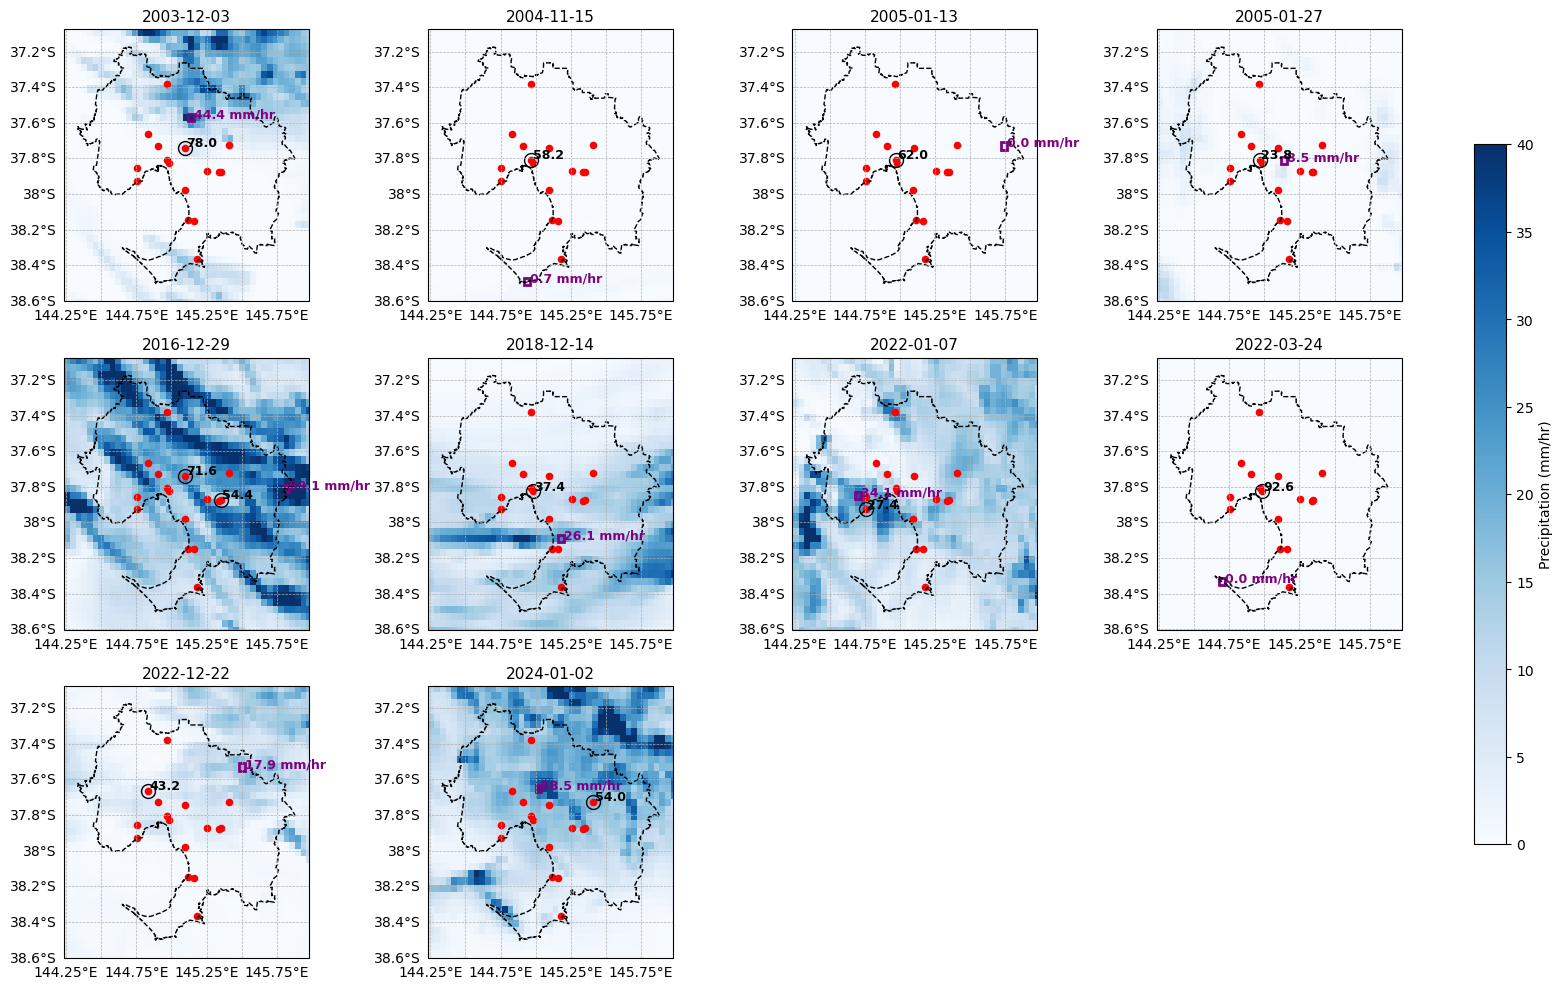

In [6]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.vectorized import contains
import matplotlib.patches as mpatches

# --- File paths ---
base_path = "/g/data/w28/yk8692/nesp"
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004"
summary_file = f"{base_path}/figure/Melbourne_top10_extreme_events_ranked_with_latlon.csv"
stations_file = f"{base_path}/station/All_stations_information.xlsx"
shp_path = f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# --- Load Top 10 Summary and extract dates ---
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
df['date'] = df['Datetime_10min_Max'].dt.date
dates = sorted(df['date'].unique())
print("Top event dates:", dates)

# --- Load shapefile and stations ---
gccsa = gpd.read_file(shp_path)
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)].to_crs(epsg=4326)
minx, miny, maxx, maxy = mel_shp.total_bounds

stations = pd.read_excel(stations_file)
stations_gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude), crs="EPSG:4326")
stations_in_region = stations_gdf[stations_gdf.within(mel_shp.unary_union)]

# Use a reference file to create mesh grid
ds_ref = xr.open_dataset(f"{barra_path}/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc")
lon, lat = ds_ref['lon'].values, ds_ref['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)
ds_ref.close()

mask = contains(mel_shp.unary_union, lon2d, lat2d)
lon_res, lat_res = np.mean(np.diff(lon)), np.mean(np.diff(lat))

# --- Create subplots ---
ncols = 4
nrows = int(np.ceil(len(dates) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, date in enumerate(dates):
    ax = axes[idx]
    year, month = date.year, date.month
    ncname = f"pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{year}{month:02d}-{year}{month:02d}.nc"
    ds = xr.open_dataset(os.path.join(barra_path, ncname))
    ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('Australia/Melbourne')
    ds_day = ds.sel(time=str(date))
    daily_max = ds_day['pr'].max(dim='time') * 3600  # mm/hr
    ds.close()

    masked = np.where(mask, daily_max.values, np.nan)
    i_max, j_max = np.unravel_index(np.nanargmax(masked), masked.shape)
    max_val, max_lon, max_lat = masked[i_max, j_max], lon2d[i_max, j_max], lat2d[i_max, j_max]

    pcm = ax.pcolormesh(lon2d, lat2d, daily_max, cmap='Blues', vmin=0, vmax=40, shading='auto', transform=ccrs.PlateCarree())

    # Boundary and max box
    mel_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='--', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle((max_lon - lon_res/2, max_lat - lat_res/2), lon_res, lat_res,
                                    linewidth=2, edgecolor='purple', facecolor='none', transform=ccrs.PlateCarree()))
    ax.text(max_lon + lon_res/2, max_lat, f'{max_val:.1f} mm/hr', fontsize=9, color='purple', fontweight='bold', transform=ccrs.PlateCarree())

    # AWS stations
    stations_in_region.plot(ax=ax, color='red', markersize=20, transform=ccrs.PlateCarree())

    # Overlay top stations
    top_stations = df[df['date'] == date]
    for _, row in top_stations.iterrows():
        ax.plot(row['Longitude'], row['Latitude'], marker='o', markersize=10,
                markerfacecolor='none', markeredgecolor='black', linewidth=2, transform=ccrs.PlateCarree())
        ax.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01, f"{row['Daily_Max_1h']:.1f}",
                fontsize=9, fontweight='bold', transform=ccrs.PlateCarree())

    ax.set_extent([minx - 0.1, maxx + 0.1, miny - 0.1, maxy + 0.1])
    ax.set_title(str(date), fontsize=11)
    # ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Add gridlines and disable top/right labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    
# Turn off unused axes
for ax in axes[len(dates):]:
    ax.set_visible(False)

# Colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Precipitation (mm/hr)')

# plt.suptitle("Daily Max Precipitation from BARRA across Top Event Dates", fontsize=16)
plt.savefig(f"{base_path}/figure/barra_top10_subplot_separate_day.jpg", dpi=300, bbox_inches='tight')
plt.show()

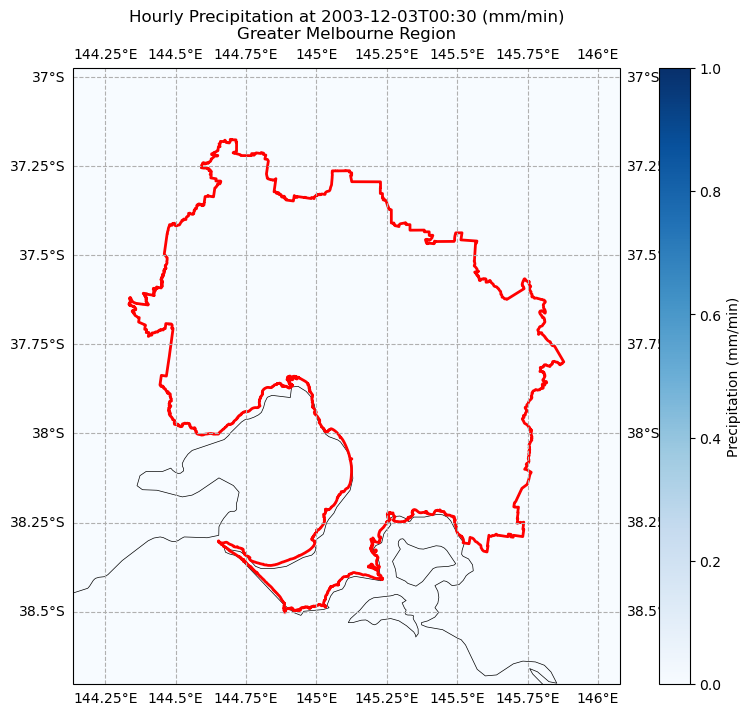

In [8]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load NetCDF data
ncfile = '/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc'
ds = xr.open_dataset(ncfile)

# Select specific timestamp
specific_time = '2003-12-03T00:00:00'
precip_hour = ds['pr'].sel(time=specific_time, method='nearest')

# Convert units to mm/min
precip_mm_min = precip_hour * 60  # (kg m-2 s-1 to mm/min)

# Explicitly get coordinates
lons = ds['lon'].values
lats = ds['lat'].values

# Create meshgrid
lon2d, lat2d = np.meshgrid(lons, lats)

# Load shapefile for Melbourne
file_path = '/g/data/w28/yk8692/nesp'
gccsa = gpd.read_file(f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)].to_crs(epsg=4326)

# Melbourne bounding box
minx, miny, maxx, maxy = mel_shp.total_bounds

# Plot with correct meshgrid coordinates
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define color scale suitable for hourly precipitation
vmin, vmax = 0, 1  # adjust based on typical data range

# Plot precipitation using pcolormesh (accurate spatial plotting)
pcm = ax.pcolormesh(lon2d, lat2d, precip_mm_min, cmap='Blues', vmin=vmin, vmax=vmax,
                    shading='auto', transform=ccrs.PlateCarree())
plt.colorbar(pcm, ax=ax, label='Precipitation (mm/min)')

# Overlay shapefile boundary
mel_shp.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':', linewidth=0.5)
ax.gridlines(draw_labels=True, linestyle='--')

# Zoom into Melbourne with precise extent
padding = 0.2
ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding])

ax.set_title(f'Hourly Precipitation at {str(precip_hour.time.values)[:16]} (mm/min)\nGreater Melbourne Region')

plt.show()


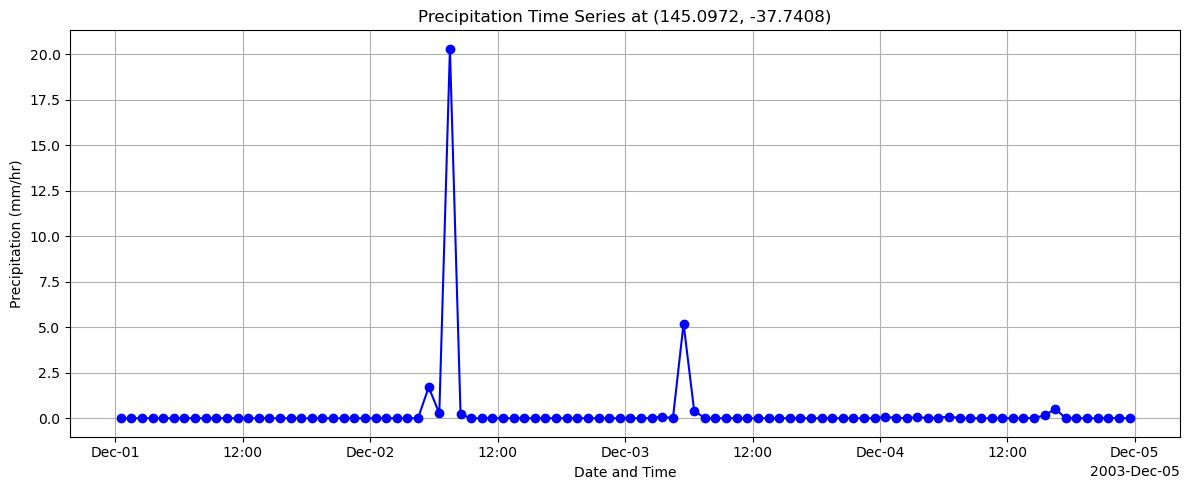

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the dataset
ncfile = '/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc'
ds = xr.open_dataset(ncfile)

# Specify coordinates
lon_pt, lat_pt = 145.09720, -37.74080

# Select nearest grid point to your specified coordinates
precip_point = ds['pr'].sel(
    lon=lon_pt, lat=lat_pt, method='nearest'
)

# Convert units to mm/hr for intuitive interpretation
precip_point_mm_hr = precip_point * 3600

# Select time range
start_date = '2003-12-01'
end_date = '2003-12-04'
precip_series = precip_point_mm_hr.sel(time=slice(start_date, end_date))

# Plotting time series
fig, ax = plt.subplots(figsize=(12, 5))
precip_series.plot(ax=ax, marker='o', linestyle='-', color='b')

ax.set_title(f'Precipitation Time Series at ({lon_pt}, {lat_pt})')
ax.set_xlabel('Date and Time')
ax.set_ylabel('Precipitation (mm/hr)')
ax.grid(True)

plt.tight_layout()
plt.show()


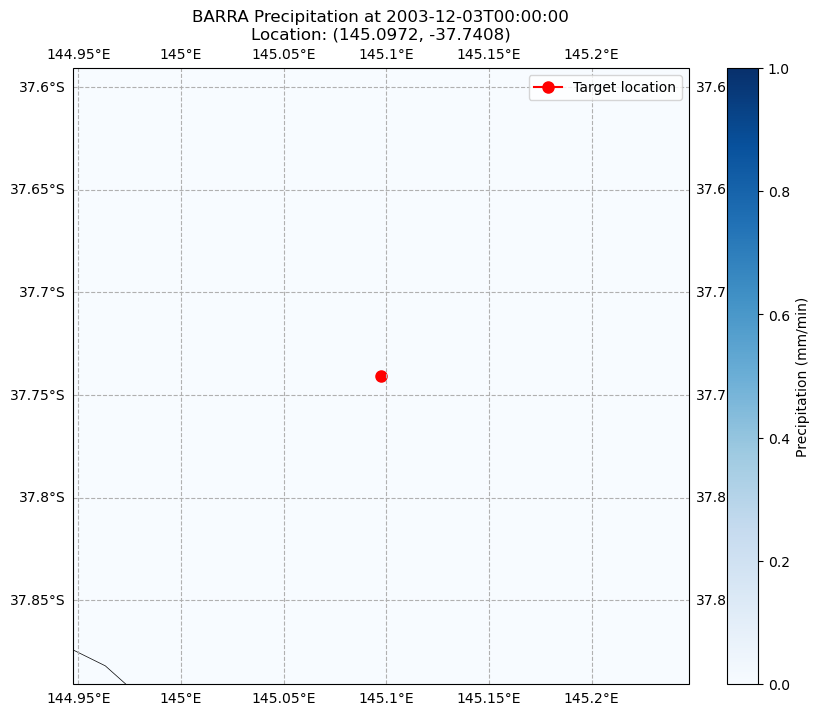

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load dataset
ncfile = '/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/v20241004/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_200312-200312.nc'
ds = xr.open_dataset(ncfile)

# Extract data for specific time
specific_time = '2003-12-03T00:00:00'
precip_hour = ds['pr'].sel(time=specific_time, method='nearest') * 60  # mm/min

# Coordinates
lons = ds['lon'].values
lats = ds['lat'].values
lon2d, lat2d = np.meshgrid(lons, lats)

# Target location
target_lon, target_lat = 145.09720, -37.74080

# Plotting the map
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot precipitation data
pcm = ax.pcolormesh(lon2d, lat2d, precip_hour, cmap='Blues', shading='auto',
                    vmin=0, vmax=1, transform=ccrs.PlateCarree())
plt.colorbar(pcm, ax=ax, label='Precipitation (mm/min)')

# Highlight the target location
ax.plot(target_lon, target_lat, marker='o', color='red', markersize=8,
        transform=ccrs.PlateCarree(), label='Target location')

# Set extent for clear zoom around the target location
zoom_padding = 0.15
ax.set_extent([target_lon - zoom_padding, target_lon + zoom_padding,
               target_lat - zoom_padding, target_lat + zoom_padding])

# Add geographic context
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':', linewidth=0.5)
ax.gridlines(draw_labels=True, linestyle='--')

ax.set_title(f'BARRA Precipitation at {specific_time}\nLocation: ({target_lon}, {target_lat})')

# Legend for clarity
ax.legend(loc='upper right')

plt.show()
